In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os
import urllib.request

To ensure that we always have an available copy of the data, we will dowload it and keep a local version. If we already have a local version we wont download the data again.

In [7]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"
data_file = "chickenpox.csv"
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

In [8]:
raw_data = pd.read_csv(data_file, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202319          7   9377     6090   12664      14           9   
1     202318          7  10671     7291   14051      16          11   
2     202317          7   9184     6162   12206      14           9   
3     202316          7  11387     8014   14760      17          12   
4     202315          7  14040     7613   20467      21          11   
5     202314          7  15247    11032   19462      23          17   
6     202313          7  13322     9700   16944      20          15   
7     202312          7  10374     7218   13530      16          11   
8     202311          7   4919     2880    6958       7           4   
9     202310          7   4854     2731    6977       7           4   
10    202309          7   7004     4548    9460      11           7   
11    202308          7   8175     5316   11034      12           8   
12    202307          7   6595     3782    9408      10           6   
13    202306          7   9595     6017   13173      14           9   
14    202305          7   6237     3907    8567       9           5   
15    202304          7   6299     3973    8625       9           6   
16    202303          7   6063     3798    8328       9           6   
17    202302          7   6576     3060   10092      10           5   
18    202301          7   8153     5470   10836      12           8   
19    202252          7   5171     2717    7625       8           4   
20    202251          7   6226     3822    8630       9           5   
21    202250          7   6590     3100   10080      10           5   
22    202249          7   5095     3212    6978       8           5   
23    202248          7   4985     3043    6927       8           5   
24    202247          7   6087     3733    8441       9           5   
25    202246          7   3033     1392    4674       5           3   
26    202245          7   3827     1720    5934       6           3   
27    202244          7   4271     2231    6311       6           3   
28    202243          7   5863     3302    8424       9           5   
29    202242          7   3770     1950    5590       6           3   
...      ...        ...    ...      ...     ...     ...         ...   
1663  199126          7  17608    11304   23912      31          20   
1664  199125          7  16169    10700   21638      28          18   
1665  199124          7  16171    10071   22271      28          17   
1666  199123          7  11947     7671   16223      21          13   
1667  199122          7  15452     9953   20951      27          17   
1668  199121          7  14903     8975   20831      26          16   
1669  199120          7  19053    12742   25364      34          23   
1670  199119          7  16739    11246   22232      29          19   
1671  199118          7  21385    13882   28888      38          25   
1672  199117          7  13462     8877   18047      24          16   
1673  199116          7  14857    10068   19646      26          18   
1674  199115          7  13975     9781   18169      25          18   
1675  199114          7  12265     7684   16846      22          14   
1676  199113          7   9567     6041   13093      17          11   
1677  199112          7  10864     7331   14397      19          13   
1678  199111          7  15574    11184   19964      27          19   
1679  199110          7  16643    11372   21914      29          20   
1680  199109          7  13741     8780   18702      24          15   
1681  199108          7  13289     8813   17765      23          15   
1682  199107          7  12337     8077   16597      22          15   
1683  199106          7  10877     7013   14741      19          12   
1684  199105          7  10442     6544   14340      18          11   
1685  199104          7   7913     4563   11263      14           8   
1686  199103          7  15387    10484   20290      27          18   
1687  199102          7  16277  

Are there missing data points? No

In [13]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Our dataset uses an uncommon encoding; the week number is attached
to the year number, leaving the impression of a six-digit integer.
That is how Pandas interprets it.

A second problem is that Pandas does not know about week numbers.
It needs to be given the dates of the beginning and end of the week.
We use the library `isoweek` for that.

Since the conversion is a bit lengthy, we write a small Python 
function for doing it. Then we apply it to all points in our dataset. 
The results go into a new column 'period'.

In [40]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

There are two more small changes to make.

First, we define the observation periods as the new index of
our dataset. That turns it into a time series, which will be
convenient later on.

Second, we sort the points chronologically.

In [57]:
sorted_data = data.set_index('period').sort_index()

We check the consistency of the data. Between the end of a period and
the beginning of the next one, the difference should be zero, or very small.
We tolerate an error of one second.

This is OK.

In [60]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

A first look at the data!

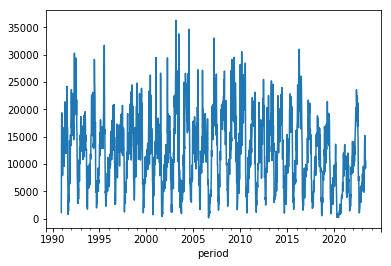

In [61]:
sorted_data['inc'].plot()

A zoom on the last few years shows more clearly that the peaks are situated in winter.

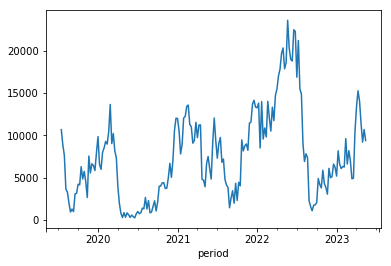

In [62]:
sorted_data['inc'][-200:].plot()

## Study of the annual incidence

In [88]:
first_december_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

We check that our periods contain between 51 and 52 weeks, as a safeguard against potential mistakes in our code.

In [90]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_december_week[:-1],
                        first_december_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Annual incidences

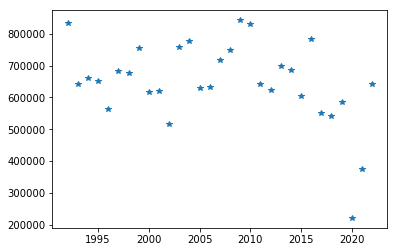

In [91]:
yearly_incidence.plot(style='*')

Sorted by value

In [92]:
yearly_incidence.sort_values()

2020    221186
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2022    641397
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64